# Streaming voice activity detection with pyannote.audio

In [28]:
# https://colab.research.google.com/github/hbredin/fastpages/blob/master/_notebooks/2021-08-05-Streaming-voice-activity-detection-with-pyannote.ipynb

# setting up for pretty visualization
# !pip install streamz
import os
print (os.environ['CONDA_DEFAULT_ENV'])

%matplotlib inline
import matplotlib.pyplot as plt

from pyannote.core import notebook, Segment, SlidingWindow
from pyannote.core import SlidingWindowFeature as SWF
notebook.crop = Segment(0, 10)

def visualize(features):
    figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (notebook.width, 2)
    notebook.plot_feature(features)

KeyError: 'CONDA_DEFAULT_ENV'

In [2]:
# Rolling audio buffer of 5s segments

from pyannote.audio.core.io import Audio, AudioFile

class RollingAudioBuffer(Audio):
    """Rolling audio buffer
    
    Parameters
    ----------
    sample_rate : int
        Sample rate
    duration : float, optional
        Duration of rolling buffer. Defaults to 5s.
    step : float, optional
        Delay between two updates of the rolling buffer. Defaults to 1s.


    Usage
    -----
    >>> buffer = RollingAudioBuffer()("audio.wav")
    >>> current_buffer = next(buffer)
    """
    def __init__(self, sample_rate=16000, duration=5.0, step=1.):
        super().__init__(sample_rate=sample_rate, mono=True)
        self.duration = duration
        self.step = step
        
    def __call__(self, file: AudioFile):
        
        # duration of the whole audio file
        duration = self.get_duration(file)
        
        # slide a 5s window from the beginning to the end of the file
        window = SlidingWindow(start=0., duration=self.duration, step=self.step, end=duration)
        for chunk in window:
            # for each position of the window, yield the corresponding audio buffer
            # as a SlidingWindowFeature instance
            waveform, sample_rate = self.crop(file, chunk, duration=self.duration)
            resolution = SlidingWindow(start=chunk.start, 
                                       duration=1./self.sample_rate, 
                                       step=1./sample_rate)
            yield SWF(waveform.T, resolution)

In [3]:
MY_AUDIO_FILE = "ES2004a.Mix-Headset.wav"
MY_RTTM_FILE = "ES2004a.Mix-Headset.rttm"
buffer = RollingAudioBuffer()(MY_AUDIO_FILE)

# import IPython
# IPython.display.Audio(MY_AUDIO_FILE)

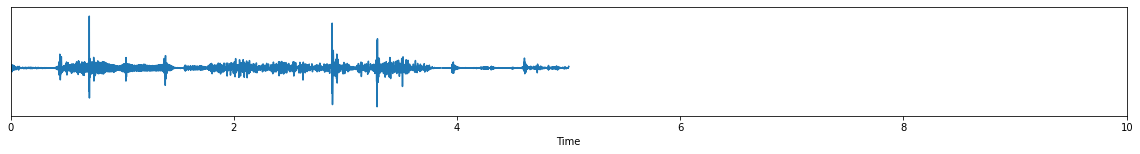

In [4]:
# Each subsequent call to next(buffer) returns the current content of the 5s rolling buffer
next(buffer)

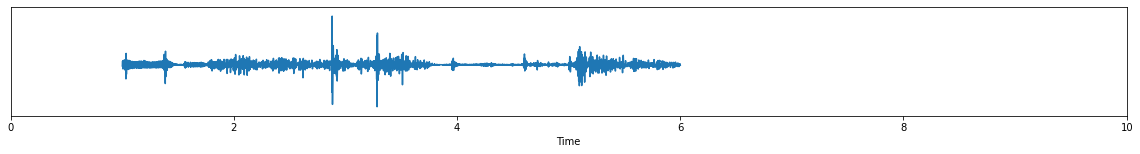

In [5]:
next(buffer)

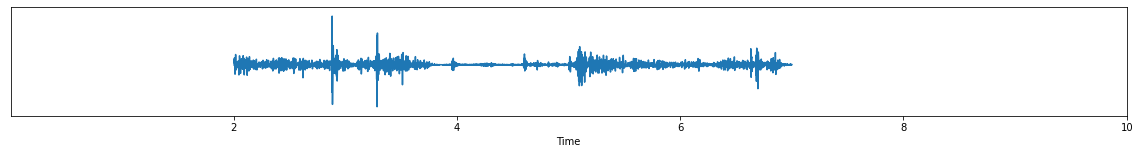

In [6]:
next(buffer)

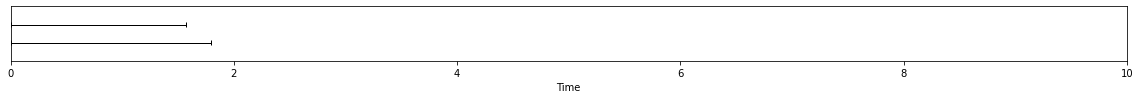

In [7]:
from pyannote.database.util import load_rttm
reference = load_rttm(MY_RTTM_FILE).popitem()[1].get_timeline()
reference

In [8]:
# Pretrained Voice activity detection model from pyannote.audio

import torch
import numpy as np
from pyannote.audio import Model

class VoiceActivityDetection:
    
    def __init__(self):
        self.model = Model.from_pretrained("pyannote/segmentation")
        self.model.eval()
        
    def __call__(self, current_buffer: SWF) -> SWF:
        
        # we start by applying the model on the current buffer
        with torch.no_grad():
            waveform = current_buffer.data.T
            segmentation = self.model(waveform[np.newaxis]).numpy()[0]

        # temporal resolution of the output of the model
        resolution = self.model.introspection.frames
        
        # temporal shift to keep track of current buffer start time
        resolution = SlidingWindow(start=current_buffer.sliding_window.start, 
                                   duration=resolution.duration, 
                                   step=resolution.step)
            
        # pyannote/segmentation pretrained model actually does more than just voice activity detection
        # see https://huggingface.co/pyannote/segmentation for more details.     
        speech_probability = np.max(segmentation, axis=-1, keepdims=True)
        
        return SWF(speech_probability, resolution)

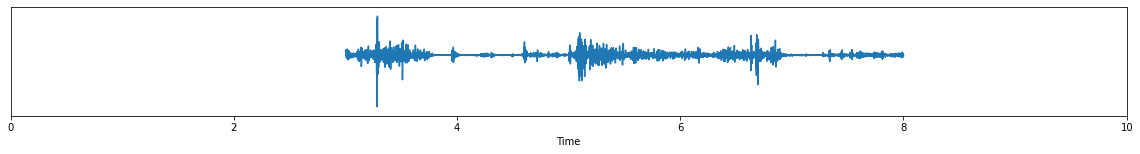

In [9]:
vad = VoiceActivityDetection()
current_buffer = next(buffer)
current_buffer

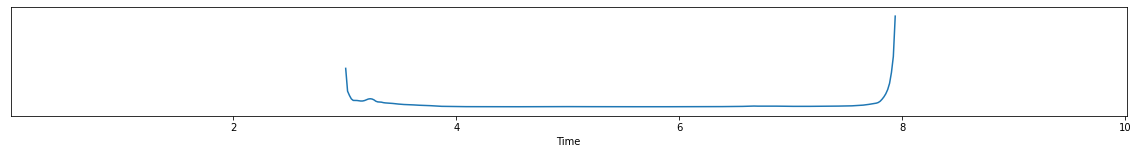

In [10]:
vad(current_buffer)

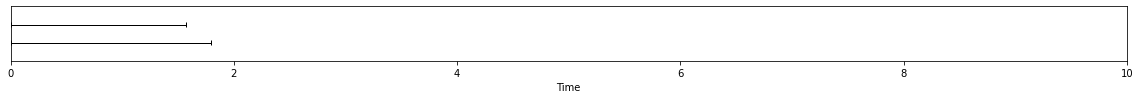

In [11]:
reference


In [12]:
# Building a basic streaming pipeline with streamz
from streamz import Stream
source = Stream()
source.map(vad).sink(visualize)

Output()

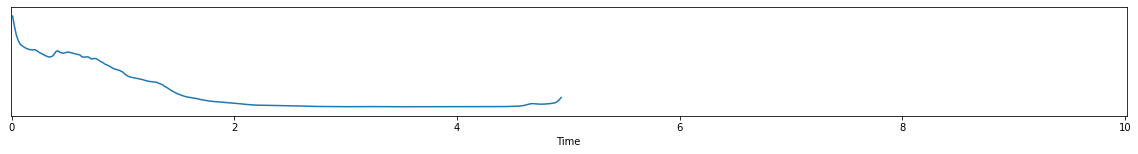

In [14]:
buffer = RollingAudioBuffer()(MY_AUDIO_FILE)
source.emit(next(buffer))

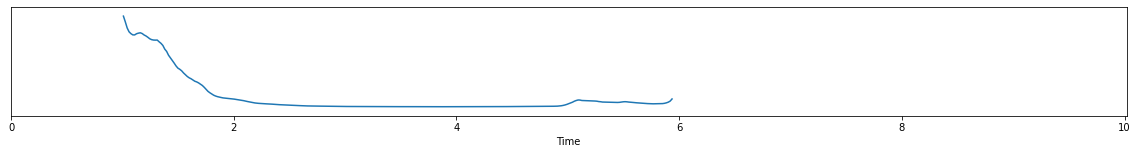

In [15]:
source.emit(next(buffer))

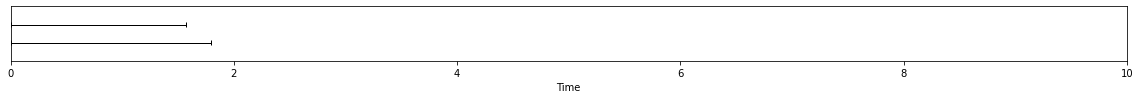

In [16]:
reference

In [17]:
# better in case the pipeline is allowed a small delay (a.k.a. latency) 
# between when it receives the audio and when it outputs the voice activity detection scores.

from typing import Tuple, List

class Aggregation:
    """Aggregate multiple overlapping buffers with a 
    
    Parameters
    ----------
    latency : float, optional
        Allowed latency, in seconds. Defaults to 0.
    """
    
    def __init__(self, latency=0.0):
        self.latency = latency
        
    def __call__(self, internal_state, current_buffer: SWF) -> Tuple[Tuple[float, List[SWF]], SWF]:
        """Ingest new buffer and return aggregated output with delay

        Parameters
        ----------
        internal_state : (internal_time, past_buffers) tuple
            `internal_time` is a float such that previous call emitted aggregated scores up 
            to time `delayed_time`.  `past_buffers` is a rolling list of past buffers that 
            we are going to aggregate.
        current_buffer : SlidingWindowFeature
            New incoming score buffer.
        """

        if internal_state is None:
            internal_state = (0.0, list())
        
        # previous call led to the emission of aggregated scores up to time `delayed_time`
        # `past_buffers` is a rolling list of past buffers that we are going to aggregate
        delayed_time, past_buffers = internal_state
        
        # real time is the current end time of the audio buffer
        # (here, estimated from the end time of the VAD buffer)
        real_time = current_buffer.extent.end
        
        # because we are only allowed `self.latency` seconds of latency, this call should
        # return aggregated scores for [delayed_time, real_time - latency] time range. 
        required = Segment(delayed_time, real_time - self.latency)
        
        # to compute more robust scores, we will combine all buffers that have a non-empty
        # temporal intersection with required time range. we can get rid of the others as they
        # will no longer be needed as they are too far away in the past.
        past_buffers = [buffer for buffer in past_buffers if buffer.extent.end > required.start] + [current_buffer]
        
        # we aggregate all past buffers (but only on the 'required' region of interest)
        intersection = np.stack([buffer.crop(required, fixed=required.duration) for buffer in past_buffers])
        aggregation = np.mean(intersection, axis=0)
        
        # ... and wrap it into a self-contained SlidingWindowFeature (SWF) instance
        resolution = current_buffer.sliding_window
        resolution = SlidingWindow(start=required.start, duration=resolution.duration, step=resolution.step)
        output = SWF(aggregation, resolution)
        
        # we update the internal state
        delayed_time = real_time - self.latency
        internal_state = (delayed_time, past_buffers)
        
        # ... and return the whole thing for next call to know where we are
        return internal_state, output

In [18]:
source = Stream()
source \
    .map(vad) \
    .accumulate(Aggregation(latency=2.), returns_state=True, start=None) \
    .sink(visualize)

buffer = RollingAudioBuffer()(MY_AUDIO_FILE)

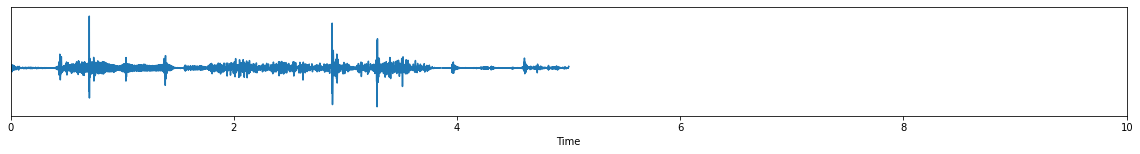

In [19]:
# first [0s, 5s] buffer
current_buffer = next(buffer); current_buffer

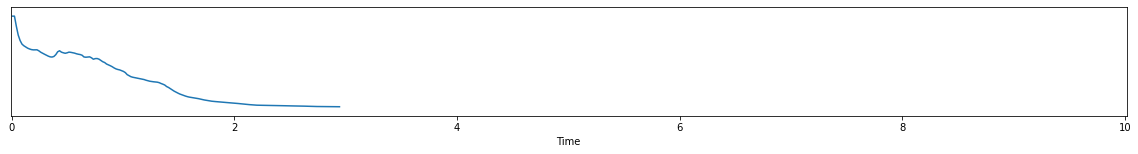

In [20]:
# ... and its corresponding output up to 3s (= 5s - latency)
source.emit(current_buffer)

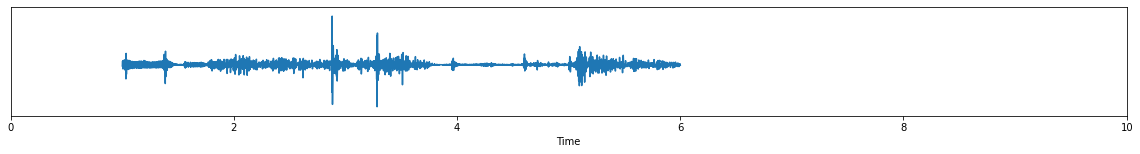

In [21]:
# next [1s, 6s] buffer
current_buffer = next(buffer); current_buffer

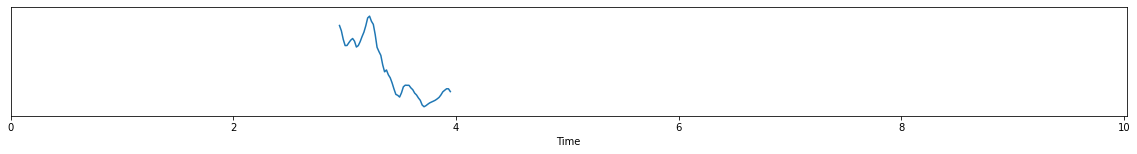

In [22]:
# ... and its corresponding [3s, 6s - latency = 4s] output
source.emit(current_buffer)

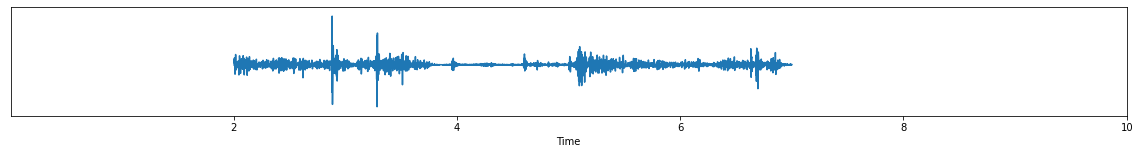

In [23]:
# next [2s, 7s] buffer
current_buffer = next(buffer); current_buffer

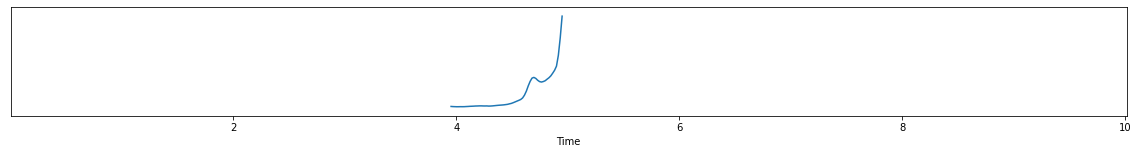

In [24]:
# ... and its corresponding [4s, 7s - latency = 5s] output
source.emit(current_buffer)

In [25]:
# concatenating output
# For visualization purposes, you might want to add an accumulator to the pipeline that takes care of concatenating the output of each step...
class Concatenation:
    
    def __call__(self, concatenation: SWF, current_buffer: SWF) -> Tuple[SWF, SWF]:
        
        if concatenation is None:
            return current_buffer, current_buffer
        
        resolution = concatenation.sliding_window
        current_start_frame = resolution.closest_frame(current_buffer.extent.start)
        current_end_frame = current_start_frame + len(current_buffer)
        
        concatenation.data = np.pad(concatenation.data, ((0, current_end_frame - len(concatenation.data)), (0, 0)))
        concatenation.data[current_start_frame: current_end_frame] = current_buffer.data        
        
        return concatenation, concatenation
    
source = Stream()
source \
    .map(vad) \
    .accumulate(Aggregation(latency=2.), returns_state=True, start=None) \
    .accumulate(Concatenation(), returns_state=True, start=None) \
    .sink(visualize)

buffer = RollingAudioBuffer()(MY_AUDIO_FILE)

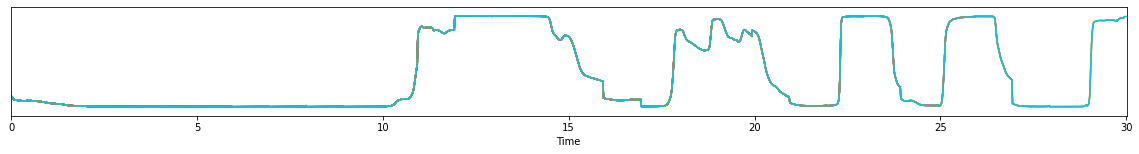

In [26]:
notebook.crop = Segment(0, 30)
for _ in range(30):
    source.emit(next(buffer))

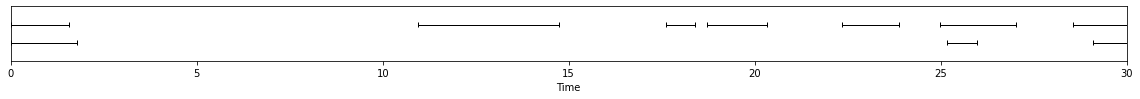

In [27]:
reference

In [13]:
# MY_AUDIO_FILE = "20220405_1746_919580755892_12220504.wav"
# from pyannote.audio import Pipeline
# pipeline = Pipeline.from_pretrained("pyannote/voice-activity-detection")
# output_vad = pipeline(MY_AUDIO_FILE)
# output_vad